# Capstone Project 

**BrainStation Data Science Bootcamp - Machine Learning Project**

**Author: L Gavrilova**

**Date: 10 November 2023**

# Notebook 3A. Labelled Dataset - Modelling

## Introduction

In this notebook I perform basic modelling for the labelled dataset. This notebook consists of the following sections:

* 3.0. Loading the data and perfoming data quality checks. 
* 3.1. Regression preparation. Assigning target variable y. Custom tokenization function is defined. Train and text split is made. 
* 3.2. Vectorization.  Most common words identified.  SMOTE sampling set up due to imbalance in data.
* 3.3. Simple logistic regression. Positive and negative coefficients for word tokens. 
* 3.4. Gridsearch for the best logistic regression model. 
* 3.5. Decision Tree Classifier
* 3.6. VADER sentiment analyser.
* 3.7. Textblob from NLTK
* 3.8. Conclusions

## 3.0 Data loading and data quality checks

In [4]:
import re
import numpy as np
import pandas as pd

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization and pandas display options
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.style.use('ggplot')
pd.set_option('display.float_format', '{:.2f}'.format)

# NLP Libraries
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Sentiment Analysis Libraries
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Machine Learning Libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, recall_score, 
                             precision_score, confusion_matrix, f1_score, roc_curve, auc,
                             roc_auc_score, ConfusionMatrixDisplay)
from sklearn.model_selection import (train_test_split, GridSearchCV, 
                                     cross_val_score)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# SMOTE for dealing with imbalanced datasets
from imblearn.over_sampling import SMOTE

In [3]:
DATAFILE = '../data/02_labelled_dataset_wo_emoji.csv'
df = pd.read_csv(DATAFILE)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4996 entries, 0 to 4995
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   link_id     4996 non-null   object
 1   parent_id   4996 non-null   object
 2   User        4996 non-null   object
 3   Text        4996 non-null   object
 4   Intent      4996 non-null   object
 5   Support     4996 non-null   object
 6   emoji_text  742 non-null    object
dtypes: object(7)
memory usage: 273.3+ KB


In [4]:
df.describe()

,link_id,parent_id,User,Text,Intent,Support,emoji_text
count,4996,4996,4996,4996,4996,4996,742
unique,1944,3148,4659,4940,5,4,382
top,t3_ladzdt,t3_ladzdt,AutoModerator,GME,u,y,🚀 🚀 🚀
freq,66,46,14,22,3247,2473,66


In [5]:
df['Intent'].value_counts()

Intent
u    3247
y     983
m     370
i     313
n      83
Name: count, dtype: int64

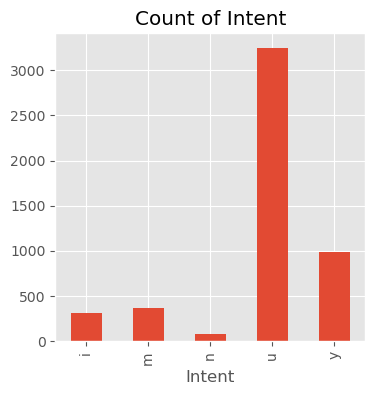

In [6]:
ax = df['Intent'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Intent',
          figsize=(4, 4))
ax.set_xlabel('Intent')
plt.show()

* Majority of posts (2/3) received clasification 'u', which means 'uncertain'. 
* 20% of posts were rated as "positive" signalling an intent to buy GME shares.
* Only a very small % of messages were rated as "negative" which creates an  imbalance in our set.  We have a deficit of examples of negative posts. 

## 3.1. Assigning target variable

In [6]:
df.sample(5)

,link_id,parent_id,User,Text,Intent,Support,emoji_text
2721,t3_l19k9r,t1_gjz5ywi,millionreddit617,"Oh dude, this is it, game over, prepare for li...",u,y,🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🥜
1050,t3_m28d30,t1_gqiwn5l,lemminghunter01,"Haha I know that one, any others you like? I'm...",m,u,NaN
3957,t3_lw7z8v,t1_gphjxrz,RBM100,"GME, in top left corner. Looks like 15 minute...",u,u,NaN
395,t3_l2bcx0,t3_l2bcx0,Mammoth_Call_214,At this point we all know what needs to be don...,u,y,NaN
2392,t3_l6ea1b,t3_l6ea1b,tbalonick,What world are we living in where GME and NOK ...,u,u,NaN


In the code below I assign new binary labels to the target variable "Intent".  I experimented with various approaches, for example encoding only "yes" asnwers with 1s, and the rest of teh answers as 0s.  I run all of theclassification models on various combinations of encoding.  The best results are achieved when "yes" and "maybe" categories are encoded as 1s and "uncertain", "informative", and "no" are encoded as 0s.  

In [8]:
# Two options together
df['Intent'] = np.where((df['Intent'] == 'y')  | (df['Intent'] == 'm'), 1, 0)
df['Support'] = np.where((df['Support'] == 'y') | (df['Intent'] == 'm'), 1, 0)

# Only one option
# df['Intent'] = np.where((df['Intent'] == 'y'), 1, 0)
# df['Support'] = np.where((df['Support'] == 'y'),1, 0)

df.head()

,link_id,parent_id,User,Text,Intent,Support,emoji_text
0,t3_l71j1l,t1_gl43z92,chasetate27,GME &amp; BB are not on cashapp but AMC &amp; ...,0,0,NaN
1,t3_ki3745,t3_ki3745,pmd5700,"Oh GME, you tease!",0,0,NaN
2,t3_la75n9,t3_la75n9,PigLizzard,"Dump gme, amc, nok, and bb so we can all buy s...",0,0,NaN
3,t3_lw6hoh,t1_gpfpvtf,anono87,Not a single decent double down posted? 9 bill...,0,0,NaN
4,t3_l9xqem,t3_l9xqem,gluino,Just got into $GME @ 220.,1,0,NaN


In [9]:
df['Intent'].value_counts()

Intent
0    3643
1    1353
Name: count, dtype: int64

In [10]:
df['Support'].value_counts()

Support
0    2523
1    2473
Name: count, dtype: int64

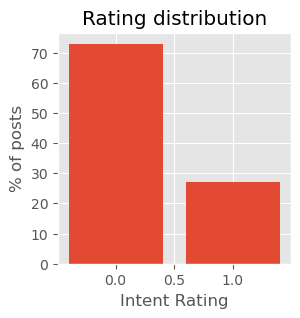

Class imbalance: [0.73 0.27]


In [12]:
values, counts = np.unique(df['Intent'], return_counts=True)
normalized_counts = counts / counts.sum()

plt.figure(figsize=(3, 3))
plt.bar(values, normalized_counts * 100)
plt.xlabel('Intent Rating')
plt.ylabel('% of posts')
plt.title("Rating distribution")
plt.show()


print(f"Class imbalance: {np.round(normalized_counts, 2)}")

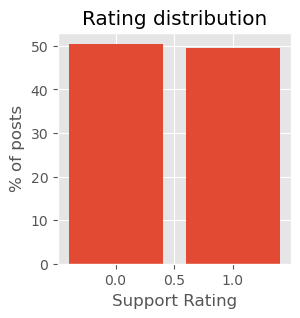

Class imbalance: [0.51 0.49]


In [13]:
values, counts = np.unique(df['Support'], return_counts=True)
normalized_counts = counts / counts.sum()

plt.figure(figsize=(3, 3))
plt.bar(values, normalized_counts * 100)
plt.xlabel('Support Rating')
plt.ylabel('% of posts')
plt.title("Rating distribution")
plt.show()
print(f"Class imbalance: {np.round(normalized_counts, 2)}")

### 2.1.1. Custom Tokenization function

In [13]:
#Load up our stop words from NLTK
stop_words = stopwords.words('english')

# Additional custom stopwords to add
custom_stopwords = ['gamestop', 'gme', 'game']

# Extend the NLTK stopwords list with custom stopwords
stop_words.extend(custom_stopwords)

In [14]:
# Defining my tokenisation function
def my_tokenizer(document, lemmatization=True, stemming=False):
    '''
    Function for use in Vectorizer that tokenizes the document.
    
    Parameters:
    - document: The text to be tokenized.
    - lemmatization: If True, perform lemmatization.
    - stemming: If True, perform stemming.
    
    Returns:
    - A list of tokens.
    '''
    
    # Replace newline characters with an empty string
    document = document.replace("\n", "")

    # Replace non-alphabetic characters with a space
    document = re.sub(r"[^a-zA-Z]", " ", document)

    # Replace multiple spaces with a single space
    document = re.sub(r"\s+", " ", document)

    # Strip leading and trailing spaces
    document = document.strip()

    # tokenize - split on whitespace
    tokenized_document = document.split(' ')

    # remove stopwords before stemming or lemmatization
    tokenized_document = [word for word in tokenized_document if word.lower() not in stop_words]

    # Perform stemming if set to True
    if stemming:
        stemmer = PorterStemmer()
        tokenized_document = [stemmer.stem(word) for word in tokenized_document]

    # Perform lemmatization if set to True
    if lemmatization:
        lemmatizer = WordNetLemmatizer()
        tokenized_document = [lemmatizer.lemmatize(word) for word in tokenized_document]

    return tokenized_document

### Train test split

In [15]:

X = df['Text']
y = df['Intent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99, stratify=y)
X_train.shape

(3996,)

## 3.2. Vectorisation 

In [16]:
# Initialise a CountVectorizer object
count_vectorizer = CountVectorizer(tokenizer=my_tokenizer,
                                   stop_words=stop_words, # using stop words list that has been customised
                                   min_df=10, 
                                   ngram_range=(1,2), 
                                   max_features=1000)

# Preprocess the stop words with the custom tokenizer
processed_stop_words = set(my_tokenizer(' '.join(stop_words)))

# Fit the CountVectorizer object on X_train
count_vectorizer.fit(X_train)

# Fit the CountVectorizer object on X_train
X_matrix_train = count_vectorizer.transform(X_train)

print(X_matrix_train.shape);

/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(3996, 1000)


In [17]:
# count the  most common words
word_counts = pd.DataFrame(
        {"counts": np.array(X_matrix_train.sum(axis=0)).flatten()},
        index=count_vectorizer.get_feature_names_out()).sort_values("counts", ascending=False)

print('The most common words and their counts are:')
word_counts[:20]

The most common words and their counts are:


,counts
optimistic,1569
super,1486
super optimistic,1472
optimistic super,1065
buy,790
investor,736
stock,708
share,675
patient,652
patient investor,645


In [18]:
#toarray() method converts sparse matrix to a DataFrame
pd.DataFrame(X_matrix_train.toarray(),columns=count_vectorizer.get_feature_names_out()).head()

,able,absolutely,access,account,across,act,action,actual,actually,add,...,ya,yall,yeah,year,yes,yesterday,yet,yo,yolo,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


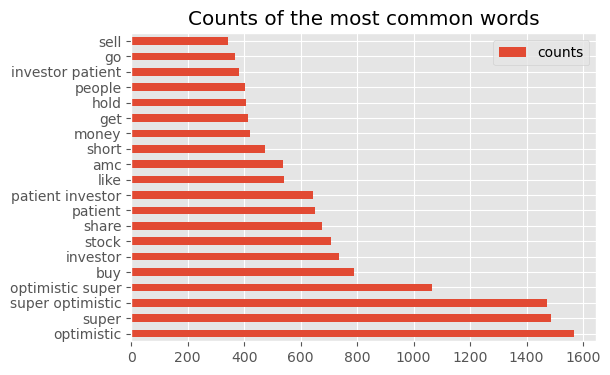

In [19]:
word_counts[:20].plot(kind='barh',title='Counts of the most common words')
plt.show()

**Observations:**

* The list of words assocaited with the messages on wallstreetbets contains a lot of words and combinations of "optimistic" and "super".  This is indicative of a heavy use of the "rocket" and "to the moon!" emojis in that community at the period when the dataset was collected.  In the previous cleaning step I have reworded such slang into plain English using phrase "super optimistic" as a translation. So, the top 4 most frequent words reflect a heavy use of the positive sentiment emojis during that period.
* Other popular words einclude words such as "buy", "share", "stock", "patient"+"investor" (this is a plain English word combination for another emoji, "the diamond hands"), "short", "money", "sell", etc. 
* Overall, the list of words is as expected from a community focused on investments and trading, but the heavy use of positive emojis at the time is clearly visible in the results. 

### SMOTE sampling due to imbalance

* My dataset is imbalanced with only 27% of data being in the positive class. 
* I decided to resample the data it using SMOTE technique (synthetic up-sampling). 
* SMOTE helps to mitigate the bias towards the majority class in an imbalanced dataset by generating synthetic samples for the minority class. 
* I expect better results as this should increase my model's ability to learn from an equally represented dataset, improving its predictive accuracy across all classes.

In [20]:
# instantiate SMOTE sampler, fit it to the training data
X_train_sm, y_train_sm = SMOTE(random_state=1).fit_resample(X_matrix_train, y_train)

In [21]:
# check what SMOTE has done

print('Original class distribution')
display(pd.Series(y_train).value_counts().sort_index())

print('\nResampled class distribution')
display(pd.Series(y_train_sm).value_counts().sort_index())

Original class distribution


Intent
0    2914
1    1082
Name: count, dtype: int64


Resampled class distribution


Intent
0    2914
1    2914
Name: count, dtype: int64

In [22]:
# scale the sampled train data and the unsampled test data
# ss_sm = StandardScaler().fit(X_train_sm)
# X_train_sm_ss = ss_sm.transform(X_train_sm)
# X_test_ss = ss_sm.transform(X_test)

## 3.3. Simple Logistic Regression

In [23]:
X_matrix_test = count_vectorizer.transform(X_test)
X_matrix_test.shape

(1000, 1000)

In [24]:
logistic_model=LogisticRegression(solver='liblinear', max_iter=1000) # Using liblinear solver - good for small datasets
logistic_model.fit(X_matrix_train,y_train)
print(f"Train set accuracy {logistic_model.score(X_matrix_train,y_train):.2f}")
print(f"Test set accuracy {logistic_model.score(X_matrix_test,y_test):.2f}")

# Make predictions on the test set
test_predictions = logistic_model.predict(X_matrix_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, test_predictions))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, test_predictions))

Train set accuracy 0.86
Test set accuracy 0.76
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.89      0.85       729
           1       0.59      0.40      0.48       271

    accuracy                           0.76      1000
   macro avg       0.69      0.65      0.66      1000
weighted avg       0.74      0.76      0.75      1000

Confusion Matrix:
[[652  77]
 [162 109]]


The simple logistic regression model shows a good performance on the training set with an accuracy of 86%. However, the test set accuracy drops to 76%, indicating a potential overfitting to the training data.  I think this is quite understandable given the small dataset I have. 

In terms of precision and recall, the model performs better on the negative class (0s), with a precision of 80% and a recall of 89%. This suggests that it is better at identifying true negatives. For the positive class (1s), the precision is lower at 59%, with a recall of 40%.  The model is less efficient for my target variable, i.e. it is less effective at identifying true intentions to buy and could benefit from further tuning.  I think this is explained by the fact that only 27% of data is in the positive class and not enough training data. 

The overall accuracy of 76% is a decent starting point, but 1) it is not very far away from 73% which is our majority class percentage, and 2) the macro-average and weighted-average scores for precision, recall, and the f1-score are not well balanced between the classes. The f1-score, which balances precision and recall, is significantly higher for the majority negative class (0.85) compared to the positive class (0.48).

The model appears to have room for improvement, especially in correctly predicting the positive class. I will explore more complex models later in this notebook.

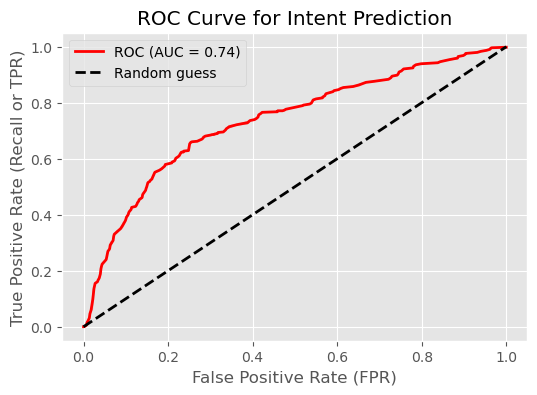

In [25]:
# probabilistic prediction
y_test_proba = logistic_model.predict_proba(X_matrix_test)[:,1] 

# ROC arrays
fprs, tprs, thresholds = roc_curve(y_test, y_test_proba)

# AUC
roc_auc = roc_auc_score(y_test, y_test_proba)

# plot
plt.figure()
sns.lineplot(x=fprs, y=tprs, color='red', lw=2, label=f'ROC (AUC = {roc_auc:0.2f})')  # Corrected line
sns.lineplot(x=[0, 1], y=[0, 1], color='black', lw=2, linestyle='--', label='Random guess')  # Corrected line and added linestyle for clarity

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (Recall or TPR)')
plt.title('ROC Curve for Intent Prediction')
plt.legend(loc='best')
plt.show()

Train set accuracy after SMOTE 0.82
Test set accuracy after SMOTE 0.64
Classification Report after SMOTE:
              precision    recall  f1-score   support

           0       0.82      0.64      0.72       729
           1       0.39      0.62      0.48       271

    accuracy                           0.64      1000
   macro avg       0.61      0.63      0.60      1000
weighted avg       0.71      0.64      0.66      1000

Confusion Matrix after SMOTE:
[[469 260]
 [102 169]]


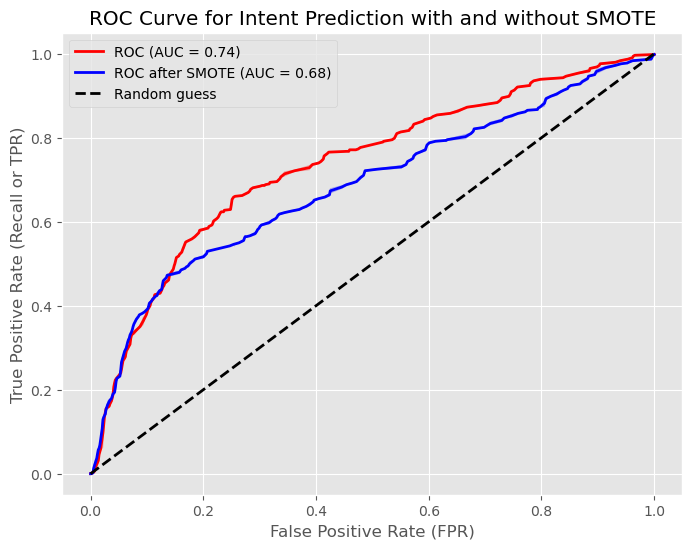

In [26]:
# Logreg with SMOTE

# Initialize the logistic regression model
logistic_model_sm = LogisticRegression(solver='liblinear', max_iter=1000)

# Fit the model on the SMOTE resampled training data
logistic_model_sm.fit(X_train_sm, y_train_sm)

# Evaluate the model on the original training set
print(f"Train set accuracy after SMOTE {logistic_model_sm.score(X_train_sm, y_train_sm):.2f}")

# Evaluate the model on the test set
print(f"Test set accuracy after SMOTE {logistic_model_sm.score(X_matrix_test, y_test):.2f}")

# Make predictions on the test set using the model trained on SMOTE data
test_predictions_sm = logistic_model_sm.predict(X_matrix_test)

# Print classification report
print("Classification Report after SMOTE:")
print(classification_report(y_test, test_predictions_sm))

# Print confusion matrix
print("Confusion Matrix after SMOTE:")
print(confusion_matrix(y_test, test_predictions_sm))

# Get probabilistic predictions
y_test_proba_sm = logistic_model_sm.predict_proba(X_matrix_test)[:,1]

# ROC arrays
fprs_sm, tprs_sm, thresholds_sm = roc_curve(y_test, y_test_proba_sm)

# AUC
roc_auc_sm = roc_auc_score(y_test, y_test_proba_sm)

# Combined Plot
plt.figure(figsize=(8, 6))  # Set the figure size for better visibility
sns.lineplot(x=fprs, y=tprs, color='red', lw=2, label=f'ROC (AUC = {roc_auc:0.2f})') # without SMOTE
sns.lineplot(x=fprs_sm, y=tprs_sm, color='blue', lw=2, label=f'ROC after SMOTE (AUC = {roc_auc_sm:0.2f})') # with SMOTE
sns.lineplot(x=[0, 1], y=[0, 1], color='black', lw=2, linestyle='--', label='Random guess')

plt.title('ROC Curve for Intent Prediction with and without SMOTE')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (Recall or TPR)')
plt.legend(loc='best')
plt.show()

* The SMOTE technique was applied to reduce imbalance in our dataset ebtween positive and negative classes.  Unfortunately, the SMOTE adjusted data did not result in a better result. Overall, the confidence of the model deteriorated compared to the baseline simple logistric regresison: macro avearges for all indicators (precision, recall, F1) have declined, and the overall test accuracy has declined, too.  

### Simple Logistic Regression - Coefficients

/var/folders/j6/lnskfknd3zz28plgqdh6w_4m0000gn/T/ipykernel_41908/2985225999.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(coef_df.tail(20)["token"], rotation=45)
/var/folders/j6/lnskfknd3zz28plgqdh6w_4m0000gn/T/ipykernel_41908/2985225999.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(coef_df.head(20)["token"], rotation=45)


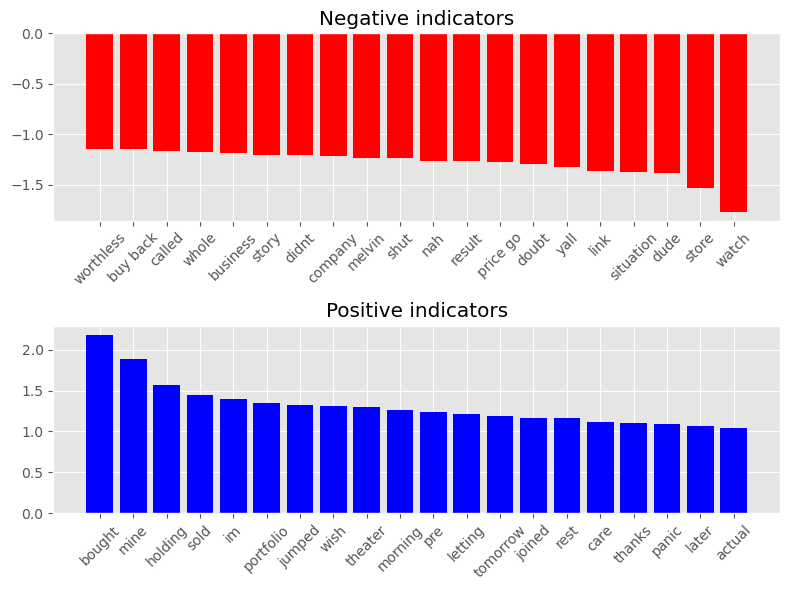

In [27]:
def plot_coefs(model):
    # Create a DataFrame to store the coefficients 
    coef_df = pd.DataFrame({"coefficient": model.coef_[0], "token": count_vectorizer.get_feature_names_out()})
    # Sort by coefficients
    coef_df = coef_df.sort_values("coefficient", ascending=False)

    # Create a figure with 2 subplots
    fig, axs = plt.subplots(2, 1, figsize=(8, 6))

    # Plot tokens with smallest coefficients
    axs[0].bar(coef_df.tail(20)["token"], coef_df.tail(20)["coefficient"], color="red")
    axs[0].set_xticklabels(coef_df.tail(20)["token"], rotation=45)
    axs[0].set_title("Negative indicators")

    # Plot tokens with largest coefficients
    axs[1].bar(coef_df.head(20)["token"], coef_df.head(20)["coefficient"], color="blue")
    axs[1].set_xticklabels(coef_df.head(20)["token"], rotation=45)
    axs[1].set_title("Positive indicators")

    fig.tight_layout()
    plt.show()

plot_coefs(logistic_model)

**Observation:**

* It is aleays useful to see the most important positive and negative word tokens coefficients.  
* Intention to buy stock is associated with words such as "bought", "holding", "morning", "tomorrow", "jumped".  However the positive list is full of words thatnormally do not necessarily show positive intentions to buy securities - many neutral words such as "portfolio", "theater" and even a contraindicating words such as "sold". This suggests that we dont have sufficient number of observations in our dataset. 
* We can see a similar picture with te negative coefficients, indicating lack of intention to buy: negative sentiment can be sensed in words such as "watch", "doubt", 'nah", "worthless". However, the list is full of neutral words such as "store", "yall", "situation", "result", "company", "business". 
* Overall, the review of coefficients suggests that the model has not been sufficiently trained to clearly distinguish positive and negative connotations. 

## 3.4. Gridsearch for logreg

* I use GridSearchCV to search over a specified parameter grid. 
* The GridSearch includes pre-processing steps: vectorisation, dimensionality reduction, logistical regression with various C-factors for regularisation. 
* GridSearchCV will use cross-validation internally, so no need to set up a separate validation set.  

In [28]:
# Pipeline composition, includes preprocessing and the classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Vectorization
    ('svd', TruncatedSVD(n_components=100)),  # Dimensionality reduction
    ('logr', LogisticRegression(solver='liblinear')) 
])

# Define the hyperparameters to search
param_grid = {
    'tfidf__max_df': [0.8, 0.85, 0.9], # this parameter allows to ignore words that appear in more than XX% of the documents. 
    'tfidf__ngram_range': [(1, 2), (1, 3)], # both unigrams and bigrams will be used as features
    'svd__n_components': [200, 250], # reduce the feature space to the top 100 components
    'logr__C': [10, 100, 200]
}

# Set up GridSearchCV to search for the best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5)

# X_train on the raw text data
grid_search.fit(X_train, y_train)

# After fitting, get the best estimator
best_model = grid_search.best_estimator_

# Predict the test set using the best model
test_predictions = best_model.predict(X_test)

In [29]:
# Calculate the accuracy
test_accuracy = accuracy_score(y_test, test_predictions)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Print the accuracy
print(f"Test Accuracy: {test_accuracy:.4f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, test_predictions))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, test_predictions))

Best hyperparameters: {'logr__C': 10, 'svd__n_components': 250, 'tfidf__max_df': 0.9, 'tfidf__ngram_range': (1, 2)}
Test Accuracy: 0.8380
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89       729
           1       0.74      0.62      0.68       271

    accuracy                           0.84      1000
   macro avg       0.80      0.77      0.78      1000
weighted avg       0.83      0.84      0.83      1000

Confusion Matrix:
[[669  60]
 [102 169]]


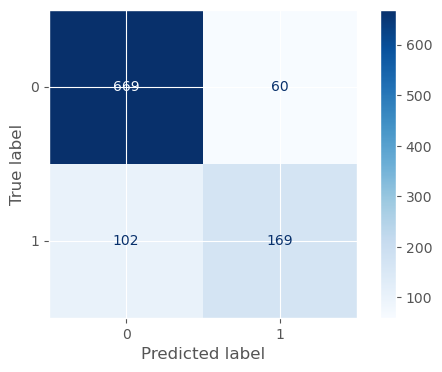

In [30]:
# Confusion matrix
cm = confusion_matrix(y_test, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Display the confusion matrix with labels
disp.plot(cmap=plt.cm.Blues)
plt.show()

**Model Interpretation:**

* The model has a high true negative rate of 0.89, meaning it is quite effective at identifying the negative cases correctly. 
* The false positive rate of relatively low at 0.11, meaning it doesn't frequently mislabel negative cases as positive.

* However, the true positive rate (Recall) is quite low at 0.40. This means that the model only correctly identifies 40% of the actual positive cases.
* The false negative rate is high at 0.60, indicating that 60% of the positive cases are missed by the model.

* The precision of 0.59 suggests that when the model predicts a case to be positive, it is correct 59% of the time. This is not high, and indicates there is sadly a significant proportion of false positives among the positive predictions.
* The F1 Score is 0.48. This relatively low score. The model is predicting positives only when very sure, and thus missing many actual positive cases.

* The model is cautious, with a tendency to predict negatives, which is likely because o fthe imbalance is data and teh small size of teh dataset. 
* This caution comes at the cost of missing a substantial number of true positives. 
* The model would benefit from adjustments to improve its recall without significantly sacrificing precision, perhaps through using the SMOTE (re-sampling the dataset), or exploring different models.

Below I am importing the best params into a pipeline for export into the big WSB dataset. 

In [31]:
# Importing the best parameters into the pipeline for further export to other notebooks
best_params = grid_search.best_params_

# Create a new pipeline with the best parameters
best_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=best_params['tfidf__max_df'],
                              ngram_range=best_params['tfidf__ngram_range'])),
    ('svd', TruncatedSVD(n_components=best_params['svd__n_components'])),
    ('logr', LogisticRegression(C=best_params['logr__C'], solver='liblinear'))
])

# Fit the best pipeline on the full training set
best_pipeline.fit(X_train, y_train)

# Best_pipeline predictions calculated 
test_predictions = best_pipeline.predict(X_test)

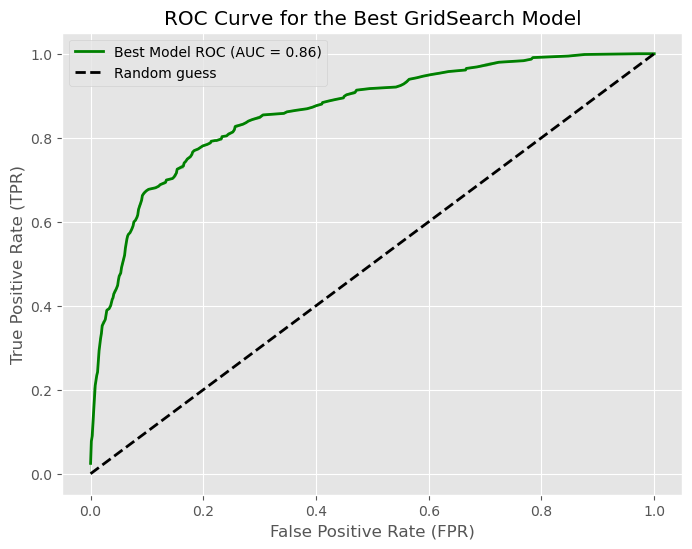

In [32]:
# Predict probabilities for the test set using bets model
y_scores_best = best_pipeline.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC for the best model
fprs_best, tprs_best, _ = roc_curve(y_test, y_scores_best)
roc_auc_best = auc(fprs_best, tprs_best)

# Plot the ROC curve for the bext model 
plt.figure(figsize=(8, 6))
sns.lineplot(x=fprs_best, y=tprs_best, color='green', lw=2, label=f'Best Model ROC (AUC = {roc_auc_best:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random guess')
plt.title('ROC Curve for the Best GridSearch Model')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='best')
plt.show()


####  Plot showing all logistical model regression ROC curves in one chart

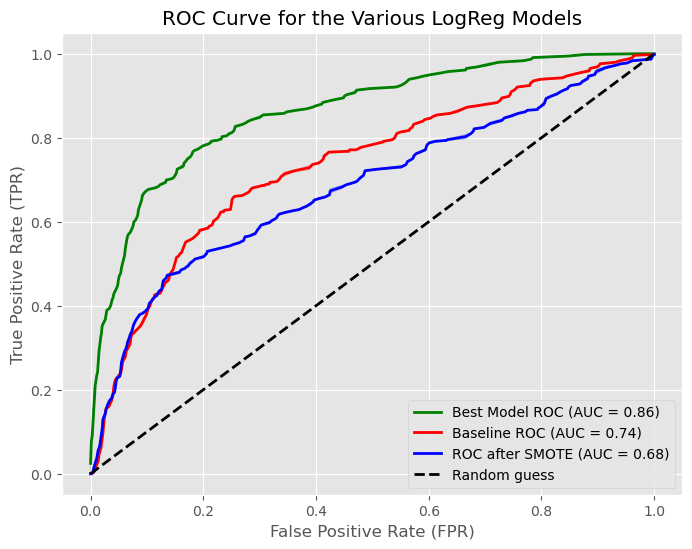

In [33]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
sns.lineplot(x=fprs_best, y=tprs_best, color='green', lw=2, label=f'Best Model ROC (AUC = {roc_auc_best:.2f})') # best model
sns.lineplot(x=fprs, y=tprs, color='red', lw=2, label=f'Baseline ROC (AUC = {roc_auc:0.2f})') # baseline
sns.lineplot(x=fprs_sm, y=tprs_sm, color='blue', lw=2, label=f'ROC after SMOTE (AUC = {roc_auc_sm:0.2f})') # with SMOTE
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random guess')

# Customize the plot
plt.title('ROC Curve for the Various LogReg Models')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='best')
plt.show()

In [15]:
# Save the best model using joblib
# joblib.dump(best_model, "../model/02_labeled_yes_best_linear_grid_search_model.pkl")
# print("Best model saved to '../model/labeled_yes_best_linear_grid_search_model.pkl'")

In [35]:
# Save the best pipline using joblib
from joblib import dump
dump(best_model, '../model/02_labelled_yes_logistic_pipeline.pkl', compress=True)

['../model/labelled_yes_logistic_pipeline.pkl']

## 3.5. Decision Tree Classifier

### 3.5.1. Set up a pipeline

In [36]:
# PCA does not support sparse input, converting sparce matrix into a dense matrix
X_matrix_train_dense = X_matrix_train.toarray()
X_matrix_test_dense = X_matrix_test.toarray()

In [37]:
# Create a pipeline with PCA and a decision tree classifier
pipeline = Pipeline([
    ('pca', PCA(n_components=20)),
    ('clf', DecisionTreeClassifier())
])

In [38]:
# Define the hyperparameters
param_grid = {
    'clf__max_depth': [1,2, 3, 5, 7, 10, 15,20], 
    'clf__min_samples_split': [2,3,4,5,6,7,8], 
    'clf__min_samples_leaf': [2,4,5,6,7,8]  
}

### 3.5.2. Hyperparameter optimization

* I use GridSearchCV to search over a specified parameter grid. 
* GridSearchCV will use cross-validation internally, so no need to set up a separate validation set.  

In [39]:
# Set up GridSearchCV 
grid_search = GridSearchCV(pipeline, param_grid, cv=5)

In [40]:
# Run the grid search on DT 
grid_search.fit(X_matrix_train_dense, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA(n_components=20)),
                                       ('clf', DecisionTreeClassifier())]),
             param_grid={'clf__max_depth': [1, 2, 3, 5, 7, 10, 15, 20],
                         'clf__min_samples_leaf': [2, 4, 5, 6, 7, 8],
                         'clf__min_samples_split': [2, 3, 4, 5, 6, 7, 8]})

In [41]:
# Print the best hyperparameters for DT Gridsearch
print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'clf__max_depth': 3, 'clf__min_samples_leaf': 8, 'clf__min_samples_split': 8}


### 3.5.3. Parameters to optimize

In [42]:
best_model = grid_search.best_estimator_

# Using the dense version of X_test, which is X_matrix_test_dense
test_preds = best_model.predict(X_matrix_test_dense)

# Accuracy using the true labels y_test and the predicted labels test_preds
val_acc = accuracy_score(y_test, test_preds)
print(f"Validation Accuracy with Best Parameters: {val_acc:.4f}")

Validation Accuracy with Best Parameters: 0.7230


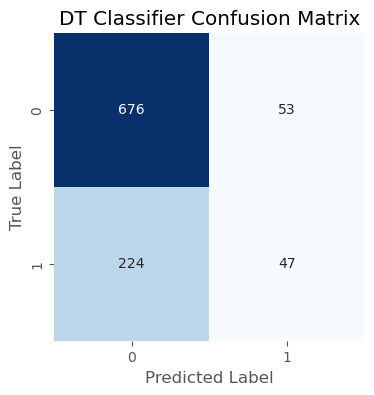

In [43]:
matrix = confusion_matrix(y_test, test_preds)

# Displaying the confusion matrix 
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('DT Classifier Confusion Matrix')
plt.show()

In [44]:
# Printing the classification report
report = classification_report(y_test, test_preds)
print(report)

              precision    recall  f1-score   support

           0       0.75      0.93      0.83       729
           1       0.47      0.17      0.25       271

    accuracy                           0.72      1000
   macro avg       0.61      0.55      0.54      1000
weighted avg       0.67      0.72      0.67      1000



**DT model interpretation**

* The Decision Tree classifier's performance, after hyperparameter tuning and grid search, shows a moderate level of accuracy at 72%, which is lower than the previously constructed logistic regression model's accuracy of 78%. 
* While the model only slightly outperforms the baseline accuracy (majority class prediction is 0 with 73% frequency). The model's ability to classify the positive class (1s) is limited, with a precision of 46% and a notably low recall of 17%. This indicates that while the model is somewhat reliable in predicting the majority class (0s), with a high recall of 93%, it frequently misses the minority class (1s), leading to a substantial number of false negatives. 
* The f1-score for the positive class also shows that the model is conservative in predicting class 1s. 
* Overall, the model is not great at all.  

## 3.6. VADER Sentiment Analyser

In this section I performed sentiment analysis using VADER (Valence Aware Dictionary and sEntiment Reasoner). 

VADER is a lexicon and a tool **specifically designed to analyse sentiments expressed in social media**. It is pre-trained and uses combinations of words labeled according to their semantic orientation as either positive or negative. VADER assigns Positivity and Negativity score. VADER is considered to be particularly good at handling sentiments expressed in short texts, such as social media messages, taking into account the context of the messages, including the use of capitalization, punctuation, and emoticons to better capture the intensity of the sentiment. So, I was quite optimistic to see the results of this analysis.  

The code in this section was borrowed and adapted from TextBlob sentiment analysis tutorial at https://pythonprogramming.net/sentiment-analysis-python-textblob-vader.  I used that tutorial to get up to speed with this classifier.

In [45]:
# Instantiate an object of SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [46]:
# This code checks the content of each inidividual text cell in the dataset and prints the post text and the VADER calculated sentiment ratings below:

i = 2048

print(df["User"].loc[i])
print(df["Text"].loc[i])
print(df["Intent"].loc[i])
print(df["Support"].loc[i])
post = df["Text"].loc[i]

# Calculates the sentiment scores for the chosen cell
overall_sentiment_score = analyzer.polarity_scores(post)
print(overall_sentiment_score)

mayhem-amigos
Just bought $40 more gme after seeing this
1
0
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In VADER documentation (https://github.com/cjhutto/vaderSentiment#about-the-scoring) it is explained that:

The VADER assigns each word a score that contributes to the overall sentiment of a sentence. This VADER score is then normalized to range between:
*  -1, indicating a strongly negative sentiment, and 
* +1, indicating a strongly positive sentiment. 

The resulting compound score for a sentence/text serves as a comprehensive single sentiment metric, and it is often used in research on social networks. 

For categorical classification, VADER recommends the following standard thresholds: 

* scores equal to or above 0.5 are deemed positive, 
* scores between -0.5 and 0.5 are considered neutral, 
* and those equal to or below -0.5 are marked negative. 

The scores for positive, neutral, and negative categories (pos, neu, and neg) represent the proportion of the text corresponding to each sentiment, cumulatively summing up to 1 or close to it.

In [47]:
# Define a function that will go through posts and assign sentimen scores to text:
def calculate_sentiment(text):
    if pd.isnull(text):
        return {'neg': None, 'neu': None, 'pos': None, 'compound': None}
    
    # Analyze the sentiment of the post
    sentiment_score = analyzer.polarity_scores(text)
    return sentiment_score

In [48]:
# Apply the calculate_sentiment function to each row in the 'title' column (runtime = 2 seconds)
sentiments = df['Text'].apply(calculate_sentiment)

# Recording the sentiments into the dataframe new columns (witha suffix "v" for vader)
df.loc[:, 'neg_v'] = sentiments.apply(lambda x: x['neg'])
df.loc[:, 'neu_v'] = sentiments.apply(lambda x: x['neu'])
df.loc[:, 'pos_v'] = sentiments.apply(lambda x: x['pos'])
df.loc[:, 'compound_v'] = sentiments.apply(lambda x: x['compound'])

In [49]:
# Bin the compound scores into categories
df['compound_v_binned'] = pd.cut(df['compound_v'], bins=[-1, -0.5, 0, 0.5, 1], labels=['Very Negative', 'Negative', 'Positive', 'Very Positive'])

# Crosstab between binned compound score and Intent
crosstab_v_intent_binned = pd.crosstab(df['compound_v_binned'], df['Intent'], rownames=['compound_v'], colnames=['Intent'])
print("\nCrosstab between binned Vader compound score and Intent:\n", crosstab_v_intent_binned)


Crosstab between binned Vader compound score and Intent:
 Intent            0    1
compound_v              
Very Negative   459  181
Negative       1462  404
Positive        743  314
Very Positive   979  454


In [50]:
df.sample(3)

,link_id,parent_id,User,Text,Intent,Support,emoji_text,neg_v,neu_v,pos_v,compound_v,compound_v_binned
70,t3_m52udt,t1_gqzsukn,LovableContrarian,More likely scenario: GME investors start gofu...,0,0,NaN,0.11,0.89,0.00,-0.10,Negative
2806,t3_kt0a9h,t3_kt0a9h,bakedToaster,"look at what they did to my boy, GME :'( gu...",1,0,NaN,0.15,0.85,0.00,-0.49,Negative
4409,t3_m16emz,t3_m16emz,Sneaksketch,Accidentally on purpose closed ark positions a...,1,0,NaN,0.13,0.73,0.14,0.03,Positive


**Observation**: 

* The distribution of messages with an intent to purchase stocks, as determined by human assigned labels (1s) is **distributed across all categories of sentiment scores**. THe sentiment score alone does not seem to be a good predictor of the intent to buy/ the label.  
* This suggests that the intention to buy may be communicated in unconventional ways, often using profanity, which may not be adequately captured by VADER's sentiment scoring. 
* The unique language of communities like wallstreetbets may not be fully recognized by VADER, which could explain the wide spread of 'intent to buy' messages across varied sentiment classifications.
* Vader has been trained on general language models, and it does not capture the financial sentiment and context well. 

Below I plot a graph that shows distribution of various VADER scores (pos, neu, neg, and compound) across my target variable classes. The compound score is a bit higher for the positive class (0.21) than for teh negative class (0.14), but this is not a massive difference given the range of the scores (from -1 to 1). 
Not a single VADER sentiment score corresponds to the intent to buy rating.  The scores are nearly the same across both negative and positive classes.  This analysis confirms my observation made above.

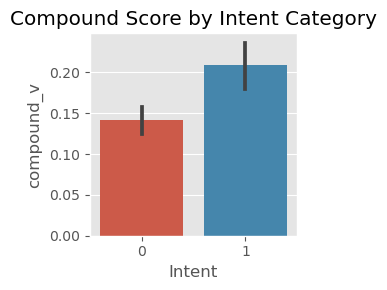

In [51]:
# Plotting graph with a compound score to show the distribution of Vader ratings
plt.figure(figsize=(3, 3))
ax = sns.barplot(data=df, x='Intent', y='compound_v')
ax.set_title('Compound Score by Intent Category')  # Corrected this line

plt.tight_layout()
plt.show()

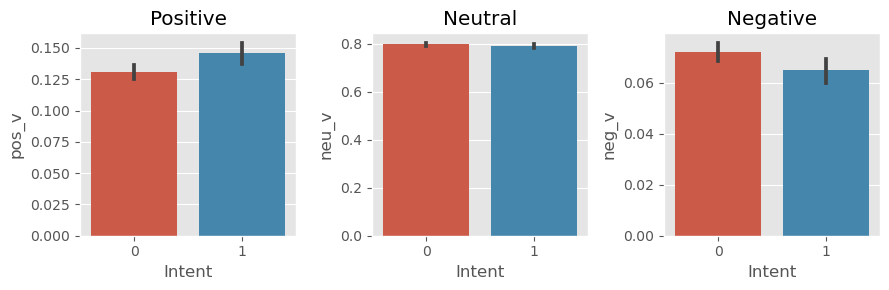

In [52]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
sns.barplot(data=df, x='Intent', y='pos_v', ax=axs[0])
sns.barplot(data=df, x='Intent', y='neu_v', ax=axs[1])
sns.barplot(data=df, x='Intent', y='neg_v', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

The correlation coefficient calcualted below indicate very low correlation between Intent and VADER scores:

In [53]:
# Features matrix (X) and target vector (y)
X = df[['neg_v','pos_v','neu_v','compound_v']]  # Using all columns as features
#X = df[['compound_v']]  # Using only compound score as feature
y = df['Intent']                 # Target variable

# Calculating the correlation of X an y
correlation = X.corrwith(y)
print(correlation)

neg_v        -0.03
pos_v         0.04
neu_v        -0.02
compound_v    0.06
dtype: float64


Just to be sure, below I built a logistic regression to check if I can spot any relationships here:

In [54]:
# Performing logistic regression

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and fit the logistic regression model to the scaled data
model_v = LogisticRegression()
model_v.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred = model_v.predict(X_test_scaled)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)

# Printing out the coefficients, the intercept, and the accuracy
print(f"Coefficients: \n{model_v.coef_}")
print(f"Intercept: {model_v.intercept_}")
print(f"Accuracy: {accuracy:.4f}")

print(classification_report(y_test, y_pred))

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Coefficients: 
[[-0.01270221  0.01248137 -0.0042442   0.10468541]]
Intercept: [-1.01456673]
Accuracy: 0.7130
              precision    recall  f1-score   support

           0       0.71      1.00      0.83       713
           1       0.00      0.00      0.00       287

    accuracy                           0.71      1000
   macro avg       0.36      0.50      0.42      1000
weighted avg       0.51      0.71      0.59      1000

Confusion Matrix:
[[713   0]
 [287   0]]


/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

**Model interpretation:**

The logistic regression model's coefficients suggest the following:

* Negative VADER sentiment is a mildly indicative of the LACK of intent to buy (as expected)
* The neg, neu, pos ratings on their own do not predict our positive class (the model coefficients are very small). 
* The combined compound score has a stronger positive relationship with our targte variable (higher compound score is indicative of a higher probability of an intent to buy stock)
* Unfortunately the model has not learned to differentiate effectively between the classes: the accuracy score is 0.7130, which seems decent at first glance,however, the confusion matrix and classification report show that the model predicted 'no intent to buy' (class 0) for all instances, resulting in a recall of 1.00 for class 0 but 0.00 for class 1. 
* The model fails to identify any true positives for the 'intent to buy' (class 1) category.

**Conclusion:**

* VADER sentiment analyser is not helpful at all in classifying our data.
* I dont think this Vader sentiment analyser works to spot an intent to buy stocks, which is understandable, as it is a completely different task from analysing the overall text sentiment. 

## 3.7. TextBlob from NLTK

In this section below I analyse the dataset with the help of one more sentiment analyser, the TextBlob from NLTK.

* TextBlob NLTM Library is similar to VADER, as it is designed to measure sentiment of a text. The sentiment is captured by a polarity score, ranging from negative (-1) to positive (+1). 
* Subjectivity is graded from 0 to 1, with 0 being very factual/objecive and 1 being very subjective. 

The code in this section was borrowed and adapted from TextBlob sentiment analysis tutorial at https://pythonprogramming.net/sentiment-analysis-python-textblob-vader.

In [55]:
# This code checks the content of each inidividual text cell and compare sentiment rating assigned by NLTK TextBlob and VADER:
i = 2014

print(df["User"].loc[i])
print(df["Text"].loc[i])
print(df["Intent"].loc[i])
print(df["Support"].loc[i])

post = df["Text"].loc[i]

# VADER (from above)
overall_sentiment_score = analyzer.polarity_scores(post)
print("VADER sentiment score:")
print(overall_sentiment_score)

# TextBlob 
analysis = TextBlob(post)
print("TextBlob sentiment score:")
print(analysis.sentiment)

fastenedseatbelt
Oh fuck oh fuck.  Abort GME. Wait for entry. 550,000 shares available to short.  They're going to do a helluva 10 am dump.
0
0
VADER sentiment score:
{'neg': 0.312, 'neu': 0.617, 'pos': 0.071, 'compound': -0.8126}
TextBlob sentiment score:
Sentiment(polarity=-0.1, subjectivity=0.47500000000000003)


In [56]:
# Reminding myself what is the class composition in our "Intent" column
df['Intent'].value_counts()
values, counts = np.unique(df['Intent'], return_counts=True)
normalized_counts = counts / counts.sum()
print(f"Class imbalance: {np.round(normalized_counts, 2)}")

Class imbalance: [0.73 0.27]


In the code below (borrowed and adapted from TextBlob sentiment analysis tutorial at https://pythonprogramming.net/sentiment-analysis-python-textblob-vader/) I calculate the totals of positive and negative posts.  

If polarity rating is >0, then I count it as a positive score, and if polarity is less than 0, then I count it as a negative sentiment.  I can compare the totals of the dataset to my distribution of categoris for 'Intent'.  

With threshhold set at zero I have too many positive ratings, so I needed to change the threshhold to dial down positivity of the dataset. I now classify polarity scores as positive only once they reach a certain threshhold, for example they need ot be above 0.2 to be counted as positive. 

By experimenting a bit, I determined that threashhold of 0.2 is a good threshhold to get to the desired distribution of 1 and 0 (hopefully matching the distribution of labels).  I am recording this calculated sentiment score into my model. 

In [57]:
# Code in this section is borrowed from TextBlob sentiment analysis tutorial at https://pythonprogramming.net/sentiment-analysis-python-textblob-vader/

pos_count = 0
pos_correct = 0

# 'Text' column to be analyzed with TextBlob
for line in df['Text']:
    analysis = TextBlob(line)
    if analysis.sentiment.polarity > .00:
        pos_correct += 1
    pos_count += 1

neg_count = 0
neg_correct = 0

for line in df['Text']:
    analysis = TextBlob(line)
    if analysis.sentiment.polarity <= 0.0:
        neg_correct += 1
    neg_count += 1

print("Positive sentiment = {:.2f}% via {} samples".format(pos_correct/pos_count*100.0, pos_count))
print("Negative sentiment = {:.2f}% via {} samples".format(neg_correct/neg_count*100.0, neg_count))


Positive sentiment = 45.06% via 4996 samples
Negative sentiment = 54.94% via 4996 samples


In [58]:
# Code in this section is borrowed from TextBlob sentiment analysis tutorial at https://pythonprogramming.net/sentiment-analysis-python-textblob-vader/

# Define a function to apply TextBlob analysis and create new columns with the sentiment ratings
def apply_textblob(sentiment_text):
    analysis = TextBlob(sentiment_text)
    subj_score = analysis.sentiment.subjectivity
    pol_score = analysis.sentiment.polarity
    sentim_score = 1 if pol_score > 0.2 else 0
    return subj_score, pol_score, sentim_score

# Apply the function and assign new columns
df[['subj_tb1', 'pol_tb1', 'sentim_tb1']] = df.apply(lambda row: apply_textblob(row['Text']), axis=1, result_type='expand')

In [59]:
# Crosstab between sentim_tb1 and Intent
crosstab_tb1_intent = pd.crosstab(df['sentim_tb1'], df['Intent'], rownames=['sentim_tb1'], colnames=['Intent'])
print("\nCrosstab between sentim_tb1 and Intent:\n", crosstab_tb1_intent)


Crosstab between sentim_tb1 and Intent:
 Intent         0    1
sentim_tb1           
0.00        2849  991
1.00         794  362


Just looking at the crosstab (the confusion matrix) I can see that a lot of the rows have been misclassified

In [60]:

X = df[['subj_tb1', 'pol_tb1']]  # Using both columns as features
y = df['Intent']                 # Intent as target variable

# Calculating the correlation of X an y
correlation = X.corrwith(y)
print(correlation)

subj_tb1   0.07
pol_tb1    0.05
dtype: float64


I will try the logistics regression below

In [70]:
# Building a logistic regression on the TextBlob sentiment analysis accuracy

X = df[['sentim_tb1']]
y = df['Intent']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the logistic regression model
model_tb = LogisticRegression()
model_tb.fit(X_train, y_train)

# Predict on the test data
y_pred = model_tb.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)

# Generating the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Printing out the metrics
print(f"Test accuracy: {accuracy:.4f}")

print(f"Confusion Matrix:\n{conf_matrix}")

print(classification_report(y_test, y_pred))

Test accuracy: 0.7130
Confusion Matrix:
[[713   0]
 [287   0]]
              precision    recall  f1-score   support

           0       0.71      1.00      0.83       713
           1       0.00      0.00      0.00       287

    accuracy                           0.71      1000
   macro avg       0.36      0.50      0.42      1000
weighted avg       0.51      0.71      0.59      1000



/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

**Model Interpretation**:

* The logistic regression model results indicate an accuracy of 71.3%, which is below our majority class of 73%. In other words, this model is performing worse than if we decided to vote for the majority class.  
* The recall, precision, and F1 score for the positive class (1s) are all 0.00, revealing that the model failed to correctly identify ANY of the actual positive instances. 
* The confusion matrix shows that the model predicted ALL test cases as the negative class (0s), with 287 false negatives and no true positives. 
* Essentially, while the model is accurate in predicting the negative class, it is entirely ineffective for the positive class. Not very practical at all. 

**Conlcusion on TextBlob and VADER sentiment indicators**:

* It is challenging to predict an intent to buy stocks based on the generic off the shelf sentiment analysers NLTK TextBlob and VADER. 
* I tried several different settings/combinations on the threshhold (for positivity and subjectivity).  Unfortunately, none of them yielded good results.
* My best model so far is the logistic regresison with optimised hyperparameters.
* As my next step I should try to build a more complex models, such as a random forest and also try to train a neural network. 